# Fine tuning OpenClip

Given an image-text pair $(x_i, y_j)$, where:
- $x_i \in \mathcal{X}$ represents an image
- $y_j \in \mathcal{Y}$ represents a text caption

CLIP learns two embedding functions:

1. **Image encoder**:
   $$
   f_\theta: \mathcal{X} \rightarrow \mathbb{R}^d \quad \text{(ViT-B/32 or ViT-B/14, $d=512$)}
   $$

2. **Text encoder**:
   $$
   g_\phi: \mathcal{Y} \rightarrow \mathbb{R}^d \quad \text{(Transformer)}
   $$


In [12]:
import torch
from PIL import Image
import open_clip
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn 


device = "cuda" if torch.cuda.is_available() else "cpu"

#model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14-quickgelu', pretrained='dfn2b')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(device)
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
#tokenizer = open_clip.get_tokenizer('ViT-L-14')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open("../openclip/docs/CLIP.png")).unsqueeze(0).to(device)
text = tokenizer(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad(), torch.autocast(device):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]


Label probs: tensor([[9.9950e-01, 4.1081e-04, 8.4776e-05]], device='cuda:0')


## Load data

In [40]:
from pathlib import Path
from collections import defaultdict
import json

####################################################################################################
#This determines which if we test on leaderboard data or not
use_leaderboard = True # or False, depending on your test
print(f"\nUsing {'leaderboard test set' if use_leaderboard else 'RSICD test set with labels'}")
####################################################################################################

# Load class names from .txt
class_txt_dir = Path("../data/txtclasses_rsicd")
filename_to_class = {}
class_names_set = set()


leaderboard_classes = [
    "agricultural", "airplane", "baseballdiamond", "beach", "buildings",
    "chaparral", "denseresidential", "forest", "freeway", "golfcourse",
    "harbor", "intersection", "mediumresidential", "mobilehomepark", "overpass",
    "parkinglot", "river", "runway", "sparseresidential", "storagetanks", "tenniscourt"
]
class_names = [] #initialise to avoid errors

if use_leaderboard:
    class_names = leaderboard_classes
else:
    class_names_set = set()
    for txt_file in sorted(class_txt_dir.glob("*.txt")):
        class_name = txt_file.stem.lower()
        class_name = class_name.replace("bareland", "bare land") \
            .replace("baseballfield", "baseball field") \
            .replace("denseresidential", "dense residential area") \
            .replace("mediumresidential", "medium-density residential area") \
            .replace("sparseresidential", "sparse residential area") \
            .replace("storagetanks", "storage tanks") \
            .replace("railwaystation", "railway station") \
            .replace("playfields", "play fields")
        class_names_set.add(class_name)
        with open(txt_file, "r") as f:
            for line in f:
                filename = line.strip()
                filename_to_class[filename] = class_name
    class_names = sorted(class_names_set)


Using leaderboard test set


# Zero-Shot Classification with Prompt Template Aggregation

For zero-shot classification with $K$ classes, we define a set of $M$ prompt templates $\mathcal{T} = \{T_1, \dots, T_M\}$ (e.g., "A photo of a {}", "A satellite image of {}", etc.). For each class $k$, we generate $M$ class-specific prompts:

$$
t_k^{(m)} = T_m(\text{class } k), \quad m = 1, \dots, M
$$

## Text Embedding Aggregation

The aggregated text embedding for class $k$ is computed as:

$$
\bar{g}_\phi(t_k) = \frac{1}{M} \sum_{m=1}^M g_\phi\left(t_k^{(m)}\right)
$$

where:
- $g_\phi(\cdot)$ is the text encoder
- All embeddings are $L_2$-normalized ($\|g_\phi(\cdot)\|_2 = 1$)

## Prediction Probability

The prediction probability for class $k$ given an image $x$ is:

$$
p(y=k|x) = \frac{\exp\left(\text{sim}\left(f_\theta(x), \bar{g}_\phi(t_k)\right)/\tau\right)}{\sum_{j=1}^K \exp\left(\text{sim}\left(f_\theta(x), \bar{g}_\phi(t_j)\right)/\tau\right)}
$$

where:
- $f_\theta(x)$ is the normalized image encoder output
- $\text{sim}(\mathbf{u}, \mathbf{v}) = \mathbf{u}^\top \mathbf{v}$ is cosine similarity
- $\tau$ is the temperature parameter (implicitly $\tau = 0.01$ when scaling by 100.0)

## Implementation Notes

This matches our PyTorch implementation where:
1. Multiple templates are generated for each class
2. Text features are averaged using `mean(dim=0)`
3. Similarity is computed via matrix multiplication after normalization

Alternative max-pooling aggregation:

$$
\bar{g}_\phi(t_k) = \max_{m \in 1,\dots,M} g_\phi\left(t_k^{(m)}\right)
$$

In [9]:

#########################################################
use_multiple_templates = False
#########################################################

templates = [
    "A photo of a {}",
    "A satellite photo of a {}",
    "A photo of a {} from above",
    "This is a {} scene",
    "It is a {}",
    "{} area",
    "An aerial view of {}",
    "An image of {}",
    "{}",
    "A remote sensing image of {}",
    "An image taken by a satellite of {}",
    "A high-resolution image of {}",
    "A picture of the {}"
]

prompt_class = [(f"A photo of a {cls}, taken from up above", cls) for cls in class_names]
label_to_prompt = {cls: prompt for prompt, cls in prompt_class}
text_prompts = [prompt for prompt, _ in prompt_class]

text_tokens = tokenizer(text_prompts).to(device)

with torch.no_grad(), torch.autocast(device):
 if use_multiple_templates:
        text_features = []
        for class_name in class_names:
            class_templates = [template.format(class_name) for template in templates]
            text_tokens = tokenizer(class_templates).to(device)
            class_text_features = model.encode_text(text_tokens)
            class_text_features = class_text_features / class_text_features.norm(dim=-1, keepdim=True)
            class_text_features = class_text_features.mean(dim=0, keepdim=True)  # Aggregate template features
            #class_text_features, _ = torch.max(class_text_features, dim=0, keepdim=True) 
            text_features.append(class_text_features)
        text_features = torch.cat(text_features, dim=0)
 else:
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

# Load dataset JSON
json_path = Path("../data/dataset_rsicd.json")
image_dir = Path("../data/RSICD_images")
leaderboard_dir = Path("../data/data4leaderboard")


with open(json_path, "r") as f:
    data = json.load(f)

# training captions
grouped = defaultdict(lambda: {"captions": [], "class_name": None, "split": None})

for entry in data["images"]:
    filename = entry["filename"]
    if filename not in filename_to_class:
        continue

    class_name = filename_to_class[filename]
    split = entry["split"]

    for sentence in entry["sentences"]:
        grouped[filename]["captions"].append(sentence["raw"])

    grouped[filename]["class_name"] = class_name
    grouped[filename]["split"] = split

#Split data set based on the descriptions in the json file
train_prompt_class = [
    (filename, grouped[filename]["captions"], grouped[filename]["class_name"], grouped[filename]["split"])
    for filename in grouped
]

#########################################################################################

# Zero-shot test, no training
test_images = [entry for entry in data["images"] if entry["split"] == "test"]
leaderboard_image_files = [f for f in leaderboard_dir.glob("*.jpg")]

# Choose images based on the mode
image_entries = leaderboard_image_files if use_leaderboard else test_images

correct = 0
total = 0
predictions = [] # List to store predictions

#for entry in test_images:
for entry in image_entries:
    filename = entry["filename"] if isinstance(entry, dict) else entry.name
    image_path = image_dir / filename if isinstance(entry, dict) else leaderboard_dir / filename


    if not image_path.exists():
        print(f"Missing image: {image_path}")
        continue

    if not use_leaderboard:
        true_class = filename_to_class.get(filename)
        if true_class is None or true_class not in class_names:
            print(f"Skipping image {filename} due to missing or unknown class label")
            continue

    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad(), torch.autocast(device):
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True) #Computes normalized features
        logits = (image_features @ text_features.T) / temperature
        probs = logits.softmax(dim=-1) #Extract probability according to report

    pred_idx = probs.argmax().item() #prediction
    pred_class = class_names[pred_idx]
    
    if not use_leaderboard:
        correct += (pred_class == true_class)
    total += 1
    predictions.append((filename, pred_class))



if use_leaderboard:
    print(f"\nPredictions completed on leaderboard test set ({len(predictions)} images).")
    print("Saving predictions to predictions.txt")
    with open("predictions.txt", "w") as f:
        for filename, predicted_class in predictions:
            f.write(f"{filename} {predicted_class}\n")
    print("Please submit predictions.txt to Codalab.")
else:
    print(f"\nZero-shot Accuracy on RSICD test set: {correct}/{total} = {correct / total:.2%}")


Zero-shot Accuracy on RSICD test set: 803/1093 = 73.47%


In [41]:
from pathlib import Path
import torch.nn.functional as F
from collections import defaultdict, Counter
import json
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Load data ---
json_path = Path("../data/dataset_rsicd.json")
image_dir = Path("../data/RSICD_images")
leaderboard_dir = Path("../data/data4leaderboard")
use_leaderboard = True  # <<< Change this flag as needed

with open(json_path, "r") as f:
    data = json.load(f)

# --- Build filename-to-class map ---
grouped = defaultdict(lambda: {"captions": [], "class_name": None, "split": None})
for entry in data["images"]:
    filename = entry["filename"]
    if filename not in filename_to_class:
        continue
    class_name = filename_to_class[filename]
    split = entry["split"]
    for sentence in entry["sentences"]:
        grouped[filename]["captions"].append(sentence["raw"])
    grouped[filename]["class_name"] = class_name
    grouped[filename]["split"] = split

# --- Select images ---
test_images = [entry for entry in data["images"] if entry["split"] == "test"]
leaderboard_image_files = list(leaderboard_dir.glob("*.jpg"))
image_entries = leaderboard_image_files if use_leaderboard else test_images

# --- Embed all images ---
image_embeddings = []
image_filenames = []
image_labels = []

with torch.no_grad():
    for entry in image_entries:
        filename = entry.name if use_leaderboard else entry["filename"]
        image_path = leaderboard_dir / filename if use_leaderboard else image_dir / filename

        if not image_path.exists():
            print(f"Missing image: {image_path}")
            continue

        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        img_feat = model.encode_image(image)
        img_feat = F.normalize(img_feat, dim=-1).cpu()
        image_embeddings.append(img_feat)
        image_filenames.append(filename)

        if not use_leaderboard:
            true_class = filename_to_class.get(filename)
            if true_class not in class_names:
                continue
            image_labels.append(class_names.index(true_class))

image_embeddings = torch.cat(image_embeddings)
if not use_leaderboard:
    image_labels = np.array(image_labels)

# --- Embed prompts ---
prompt_embeddings = []
prompt_labels = []

use_fixed_prompt = True  # or False to use all templates

for class_idx, class_name in enumerate(class_names):
    if use_fixed_prompt:
        prompt = f"This is a satellite photo of a {class_name}"
        tokens = tokenizer([prompt]).to(device)
        with torch.no_grad():
            text_feat = model.encode_text(tokens)
            text_feat = F.normalize(text_feat, dim=-1).cpu()
        prompt_embeddings.append(text_feat)
        prompt_labels.append(class_idx)
    else:
        for template in templates:
            prompt = template.format(class_name)
            tokens = tokenizer([prompt]).to(device)
            with torch.no_grad():
                text_feat = model.encode_text(tokens)
                text_feat = F.normalize(text_feat, dim=-1).cpu()
            prompt_embeddings.append(text_feat)
            prompt_labels.append(class_idx)

prompt_embeddings = torch.cat(prompt_embeddings)
prompt_labels = np.array(prompt_labels)

# --- Predict using KNN ---
k = 5
y_pred = []

for img_feat in image_embeddings:
    sim = img_feat @ prompt_embeddings.T
    topk_idxs = sim.topk(k).indices.tolist()
    topk_classes = prompt_labels[topk_idxs]
    voted_class = Counter(topk_classes).most_common(1)[0][0]
    y_pred.append(voted_class)

# --- Output ---
if use_leaderboard:
    print(f"\nPredictions completed on leaderboard test set ({len(y_pred)} images).")
    with open("predictions.txt", "w") as f:
        for filename, predicted_class_idx in zip(image_filenames, y_pred):
            predicted_class = class_names[predicted_class_idx]
            f.write(f"{filename} {predicted_class}\n")
    print("Saved predictions.txt — submit it to Codalab.")
else:
    acc = accuracy_score(image_labels, y_pred)
    f1 = f1_score(image_labels, y_pred, average="macro")
    cm = confusion_matrix(image_labels, y_pred)

    print(f"\nKNN Voting Accuracy: {acc:.4f}")
    print(f"KNN Voting F1 Score: {f1:.4f}")

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (KNN on Prompts)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()



Predictions completed on leaderboard test set (2100 images).
Saved predictions.txt — submit it to Codalab.


## Visualize images and prediction

Found 921 unlabeled images


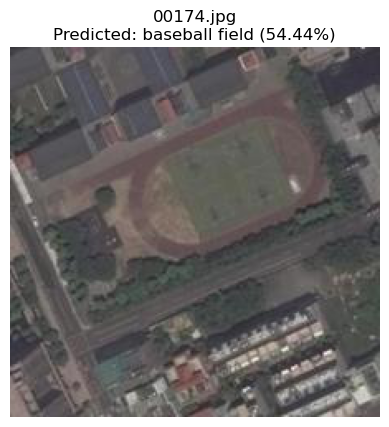

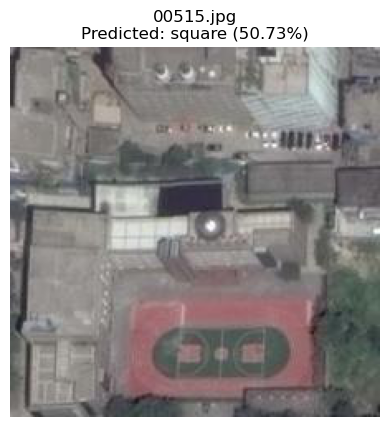

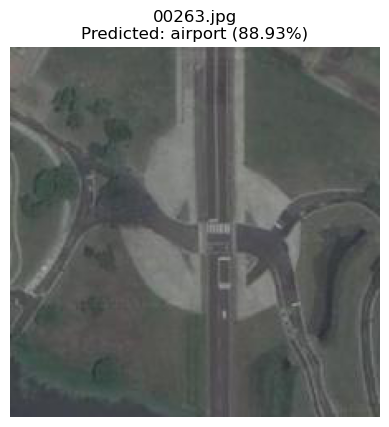

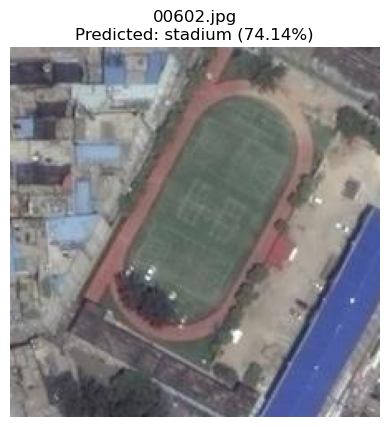

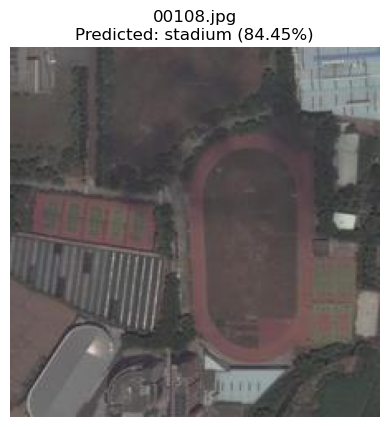

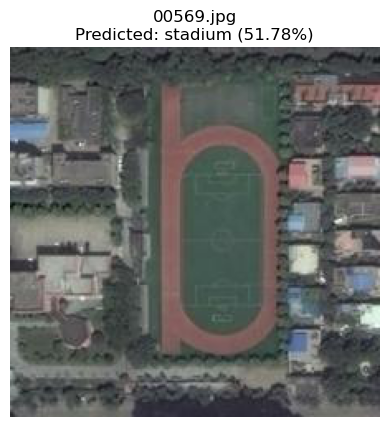

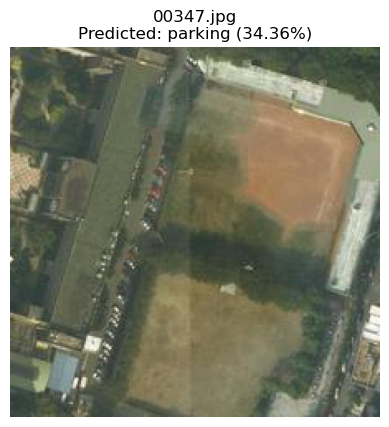

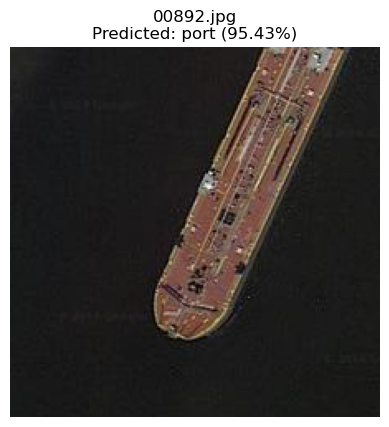

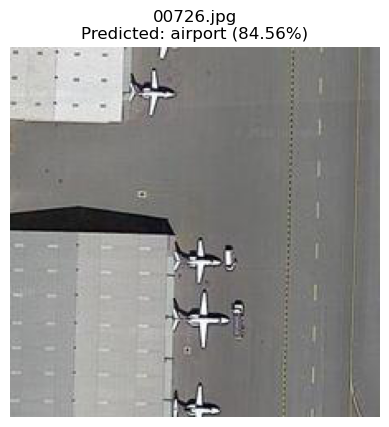

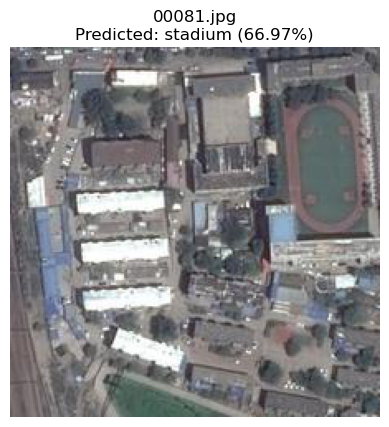

In [ ]:
import re
from PIL import Image
import matplotlib.pyplot as plt


# ONly unlabeled data
unlabeled_images = [img for img in image_dir.glob("*.jpg") if re.fullmatch(r"\d+\.jpg", img.name)]

print(f"Found {len(unlabeled_images)} unlabeled images")

# inference and show
for i, image_path in enumerate(unlabeled_images):
    if i >= 10:
        break

    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad(), torch.autocast(device):
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    pred_idx = probs.argmax().item()
    pred_class = class_names[pred_idx]
    confidence = probs[0, pred_idx].item()

    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f"{image_path.name}\nPredicted: {pred_class} ({confidence:.2%})")
    plt.show()

# Fine-tuning like pretraining

## Make trainable data set
**Use Split B as training and validation data**

In [31]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

val_entries = [entry for entry in train_prompt_class if entry[3] == "val"]

# Split the custom (filename, [captions], class_name, split) dataset
train_data, val_data = train_test_split(val_entries, test_size=0.2, random_state=42)

# Custom RSICD dataset using random caption per image
class RSICDDatasetLabeled(Dataset):
    def __init__(self, data, image_dir, transform, class_names):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.class_names = class_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, captions, class_name, _ = self.data[idx]
        image_path = self.image_dir / filename
        image = self.transform(Image.open(image_path).convert("RGB"))
        caption = random.choice(captions)
        label = class_name.lower()
        return image, caption, label, class_name

class RSICDDatasetUnlabeled(Dataset):
    def __init__(self, data, image_dir, transform):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, _, _, _ = self.data[idx]
        image_path = self.image_dir / filename
        image = self.transform(Image.open(image_path).convert("RGB"))
        return image


# 2. Labeled Datasplit, used in the fully supervised learning. The validation dataset from the json file is plit into 80% training and 20% validation 
# This enables the training loop to check validation error for early stopping
labeled_entries = [entry for entry in train_prompt_class if entry[3] == "val"]
train_labeled_data, val_labeled_data = train_test_split(labeled_entries, test_size=0.2, random_state=42)

train_loader = DataLoader(RSICDDatasetLabeled(train_labeled_data, image_dir, preprocess, class_names), batch_size=64, shuffle=True)
val_loader = DataLoader(RSICDDatasetLabeled(val_labeled_data, image_dir, preprocess, class_names), batch_size=64)


test_entries = [entry for entry in train_prompt_class if entry[3] == "test"]
test_loader = DataLoader(RSICDDatasetLabeled(test_entries, image_dir, preprocess, class_names), batch_size=64, shuffle=True)

# 2. Unlabeled Data, only used in the semi supervised learning
unlabeled_entries = [entry for entry in train_prompt_class if entry[3] == "train"]

unlabeled_dataset = RSICDDatasetUnlabeled(unlabeled_entries, image_dir, preprocess)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True)
labeled_loader_semi_super = DataLoader(RSICDDatasetLabeled(labeled_entries, image_dir, preprocess, class_names), batch_size = 128, shuffle=True)

## Supervised Training
**Using AdamW as optimizer**
**Training with each of 5 given prompts in differents epochs**

See Power-point in Teams-channel for the idea

OBS: The loss function have to be improved

This got a accuracy of 84-85% (without training: 65%)

We define the cosine similarity between two vectors $\mathbf{u}$ and $\mathbf{v}$ as:

$$
\text{sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u}^\top \mathbf{v}}{||\mathbf{u}||_2 ||\mathbf{v}||_2}
$$

where $||\cdot||_2$ denotes the $L_2$ norm.

For both the basic (Grade 3) and advanced (Grade 5) versions, we use the symmetric contrastive loss over $N$ labeled pairs $(x_i, y_i)$ from Split B:

\begin{align*}
\mathcal{L}_{\text{CLIP}} &= \frac{1}{2}\big(\mathcal{L}_{\text{image}} + \mathcal{L}_{\text{text}}\big) \\
\mathcal{L}_{\text{image}} &= -\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(\text{sim}(f_\theta(x_i), g_\phi(y_i))/\tau)}{\sum_{j=1}^N \exp(\text{sim}(f_\theta(x_i), g_\phi(y_j))/\tau)} \\
\mathcal{L}_{\text{text}} &= -\frac{1}{N}\sum_{j=1}^N \log \frac{\exp(\text{sim}(g_\phi(y_j), f_\theta(x_j))/\tau)}{\sum_{i=1}^N \exp(\text{sim}(g_\phi(y_j), f_\theta(x_i))/\tau)}
\end{align*}

where $\tau > 0$ is a learnable temperature parameter.

In [20]:
   precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
) #changed order of arguments
  

Epoch 1/20 - Avg Train Loss: 0.7920
Validation Loss: 1.4375
Validation loss improved.


Epoch 2/20 - Avg Train Loss: 0.7702
Validation Loss: 1.3701
Validation loss improved.


Epoch 3/20 - Avg Train Loss: 0.7389
Validation Loss: 1.3885
No improvement in validation loss. Patience: 1/5


Epoch 4/20 - Avg Train Loss: 0.7119
Validation Loss: 1.4395
No improvement in validation loss. Patience: 2/5


Epoch 5/20 - Avg Train Loss: 0.7142
Validation Loss: 1.4710
No improvement in validation loss. Patience: 3/5


Epoch 6/20 - Avg Train Loss: 0.6744
Validation Loss: 1.3626
Validation loss improved.


Epoch 7/20 - Avg Train Loss: 0.6933
Validation Loss: 1.3426
Validation loss improved.


Epoch 8/20 - Avg Train Loss: 0.6628
Validation Loss: 1.5022
No improvement in validation loss. Patience: 1/5


Epoch 9/20 - Avg Train Loss: 0.6529
Validation Loss: 1.4357
No improvement in validation loss. Patience: 2/5


Epoch 10/20 - Avg Train Loss: 0.6757
Validation Loss: 1.4255
No improvement in validation loss. Patience: 3/5


Epoch 11/20 - Avg Train Loss: 0.6107
Validation Loss: 1.3302
Validation loss improved.


Epoch 12/20 - Avg Train Loss: 0.6317
Validation Loss: 1.3058
Validation loss improved.


Epoch 13/20 - Avg Train Loss: 0.5856
Validation Loss: 1.3033
Validation loss improved.


Epoch 14/20 - Avg Train Loss: 0.5742
Validation Loss: 1.2974
Validation loss improved.


Epoch 15/20 - Avg Train Loss: 0.5578
Validation Loss: 1.4650
No improvement in validation loss. Patience: 1/5


Epoch 16/20 - Avg Train Loss: 0.5586
Validation Loss: 1.5763
No improvement in validation loss. Patience: 2/5


Epoch 17/20 - Avg Train Loss: 0.5421
Validation Loss: 1.3116
No improvement in validation loss. Patience: 3/5


Epoch 18/20 - Avg Train Loss: 0.4960
Validation Loss: 1.3571
No improvement in validation loss. Patience: 4/5


Epoch 19/20 - Avg Train Loss: 0.5488
Validation Loss: 1.4341
No improvement in validation loss. Patience: 5/5
Early stopping triggered.


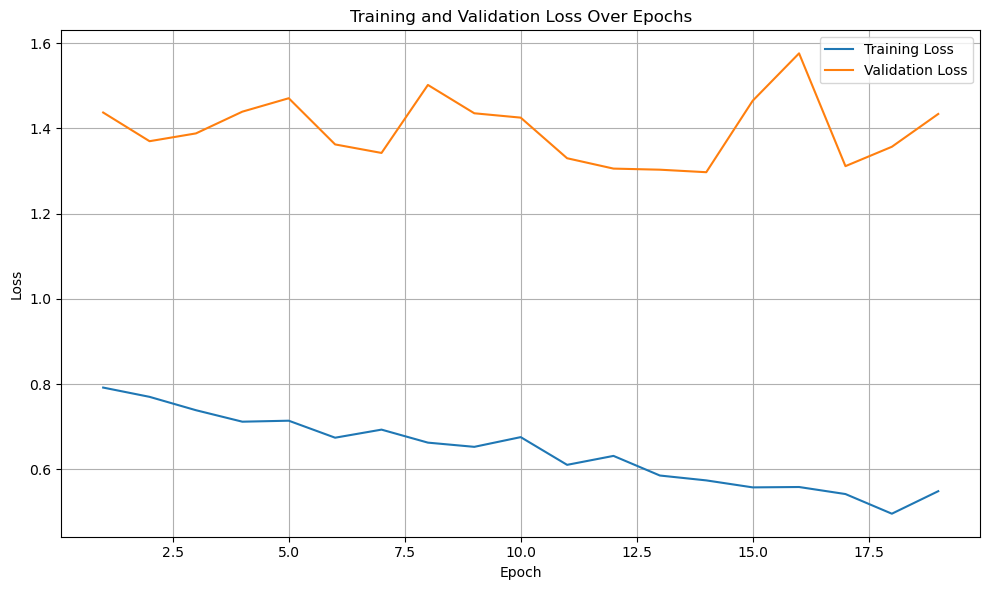


Best Temperature: 0.0698


In [ ]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn 

model.train()
initial_temperature = 0.07
temperature = nn.Parameter(torch.tensor(initial_temperature).to(device))
optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)
optimizer.add_param_group({'params': [temperature]})

torch.cuda.empty_cache()

num_epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_temperature = None

all_preds = []
all_labels = []

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for step, (images, captions, labels, class_name) in enumerate(loop):
        texts = captions if captions is not None else [f"This is a satellite photo of a {label}" for label in labels]
        tokens = tokenizer(texts).to(device)
        images = images.to(device)

        with torch.cuda.amp.autocast():
            image_features = model.encode_image(images)
            text_features = model.encode_text(tokens)

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits_per_image = image_features @ text_features.T / temperature
            logits_per_text = text_features @ image_features.T / temperature

            ground_truth = torch.arange(len(images), device=device)
            loss = (F.cross_entropy(logits_per_image, ground_truth) +
                    F.cross_entropy(logits_per_text, ground_truth)) / 2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (step + 1))

        preds = logits_per_image.argmax(dim=1).cpu().numpy()
        true_labels = [class_names.index(name) for name in class_name]
        all_preds.extend(preds)
        all_labels.extend(true_labels)

        del images, captions, labels, tokens, image_features, text_features, loss
        torch.cuda.empty_cache()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, captions, labels, class_name in val_loader:
            texts = captions if captions is not None else [f"This is a satellite photo of a {label}" for label in labels]
            tokens = tokenizer(texts).to(device)
            images = images.to(device)

            image_features = model.encode_image(images)
            text_features = model.encode_text(tokens)

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits_per_image = image_features @ text_features.T / temperature
            logits_per_text = text_features @ image_features.T / temperature

            ground_truth = torch.arange(len(images), device=device)
            loss = (F.cross_entropy(logits_per_image, ground_truth) +
                    F.cross_entropy(logits_per_text, ground_truth)) / 2

            val_loss += loss.item()
            del images, captions, labels, tokens, image_features, text_features, loss
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print("Validation loss improved.")
        best_temperature = temperature.item()
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break  # This exits the epoch loop

    model.train()

# === PLOT AFTER TRAINING ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if best_temperature is not None:
    print(f"\nBest Temperature: {best_temperature:.4f}")
else:
    print("\nNo best temperature to print.")


In [7]:
   precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
) #changed order of arguments
  

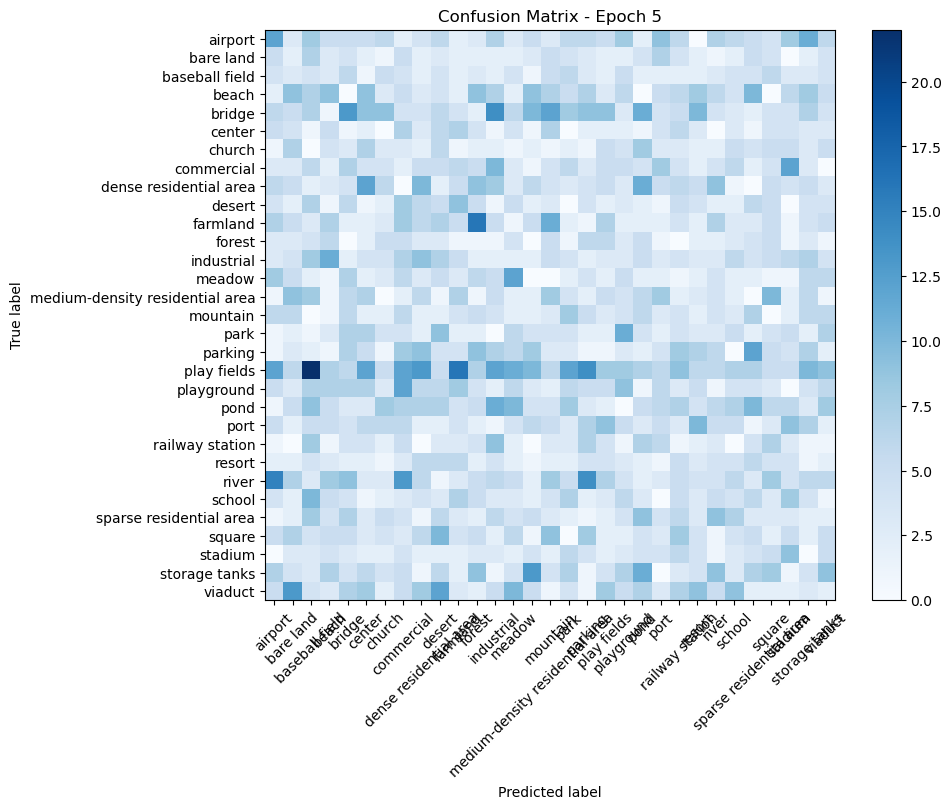

Precision (Macro): 0.0347
Recall (Macro): 0.0332
F1 Score (Macro): 0.0333


In [8]:
cm = confusion_matrix(all_labels, all_preds, labels = range(len(class_names)))
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Epoch {epoch+1}')
plt.colorbar()    
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.close()

print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

## Unsupervised Training
**This model is pretty bad right now needs improvement**


For the advanced Grade 5 version, we additionally incorporate $M$ unlabeled images $\{x_u\}$ from Split A through a consistency loss term with random augmentations $\xi,\xi'$ (cropping, color distortion) and unsupervised weight $\lambda=0.5$:
\begin{align*}
\mathcal{L}_{\text{total}} &= \mathcal{L}_{\text{CLIP}} + \lambda\mathcal{L}_{\text{consist}} \\
\mathcal{L}_{\text{consist}} &= \frac{1}{M}\sum_{u=1}^M \|f_\theta(\xi(x_u)) - f_\theta(\xi'(x_u))\|^2_2
\end{align*}

M denoted the batch size and the square resmbles the MxM matrix used to compare each of the M positive pairs with the M-1 negative pairs.

In [6]:
import torch
import random
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

class Augmentor:
    def __init__(self, image_size=224):
        self.image_size = image_size

    def random_resized_crop(self, x, scale=(0.3, 1.0)):  # more aggressive
        B, C, H, W = x.shape
        out = torch.zeros((B, C, self.image_size, self.image_size), device=x.device)
        for i in range(B):
            crop_transform = T.RandomResizedCrop(self.image_size, scale=scale)
            img = x[i]
            params = crop_transform.get_params(img, scale, (0.75, 1.0))
            img = TF.resized_crop(img, *params, size=(self.image_size, self.image_size), interpolation=InterpolationMode.BILINEAR)
            out[i] = img
        return out

    def color_jitter(self, x, brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2):
        B = x.shape[0]
        for i in range(B):
            x[i] = TF.adjust_brightness(x[i], 1 + (random.random() - 0.5) * 2 * brightness)
            x[i] = TF.adjust_contrast(x[i], 1 + (random.random() - 0.5) * 2 * contrast)
            x[i] = TF.adjust_saturation(x[i], 1 + (random.random() - 0.5) * 2 * saturation)
            x[i] = TF.adjust_hue(x[i], (random.random() - 0.5) * 2 * hue)
        return x

    def grayscale(self, x, p=0.4):
        B = x.shape[0]
        for i in range(B):
            if random.random() < p:
                x[i] = x[i].mean(dim=0, keepdim=True).repeat(3, 1, 1)
        return x

    def cutout(self, x, size=0.6):
        B, C, H, W = x.shape
        mask_h = int(H * size)
        mask_w = int(W * size)
        for i in range(B):
            top = random.randint(0, H - mask_h)
            left = random.randint(0, W - mask_w)
            x[i, :, top:top+mask_h, left:left+mask_w] = 0
        return x

    def gaussian_noise(self, x, std=0.1):
        noise = torch.randn_like(x) * std
        return (x + noise).clamp(0, 1)

    def rotate90(self, x):
        k = random.randint(0, 3)
        return torch.rot90(x, k=k, dims=(2, 3))

    def random_affine(self, x):
        B = x.shape[0]
        for i in range(B):
            x[i] = TF.affine(x[i], angle=random.uniform(-30, 30), translate=(10, 10), scale=1.0, shear=random.uniform(-15, 15))
        return x

    def channel_dropout(self, x, p=0.3):
        B, C, H, W = x.shape
        for i in range(B):
            if random.random() < p:
                c = random.randint(0, C-1)
                x[i, c] = 0
        return x

    def solarize(self, x, threshold=0.5):
        return torch.where(x < threshold, x, 1 - x)

    def __call__(self, x):
        x = self.random_resized_crop(x)

        if random.random() < 0.6:
            x = torch.flip(x, dims=[3])

        if random.random() < 0.6:
            x = self.color_jitter(x)

        if random.random() < 0.4:
            x = self.grayscale(x)

        if random.random() < 0.4:
            x = self.rotate90(x)

        if random.random() < 0.3:
            x = self.cutout(x)

        if random.random() < 0.4:
            x = self.gaussian_noise(x)

        if random.random() < 0.4:
            x = self.random_affine(x)

        if random.random() < 0.3:
            x = self.channel_dropout(x)

        if random.random() < 0.2:
            x = self.solarize(x)

        return x



augment = Augmentor(image_size=224)


def contrastive_loss(image_features1, image_features2, temperature):

     image_features1 = image_features1 / image_features1.norm(dim=-1, keepdim=True)
     image_features2 = image_features2 / image_features2.norm(dim=-1, keepdim=True)
     logits = image_features1 @ image_features2.T / temperature
     ground_truth = torch.arange(len(image_features1), device=image_features1.device) #Identify positive pairs
    # maximize the similarity between positive pairs and minimize the similarity between negative pairs within the batch.
     loss = F.cross_entropy(logits, ground_truth)
     return loss


Epoch 1/5 - Avg Loss: 6.5162


Epoch 2/5 - Avg Loss: 6.0012


Epoch 3/5 - Avg Loss: 5.6595


Epoch 4/5 - Avg Loss: 5.9821


Epoch 5/5 - Avg Loss: 5.6110


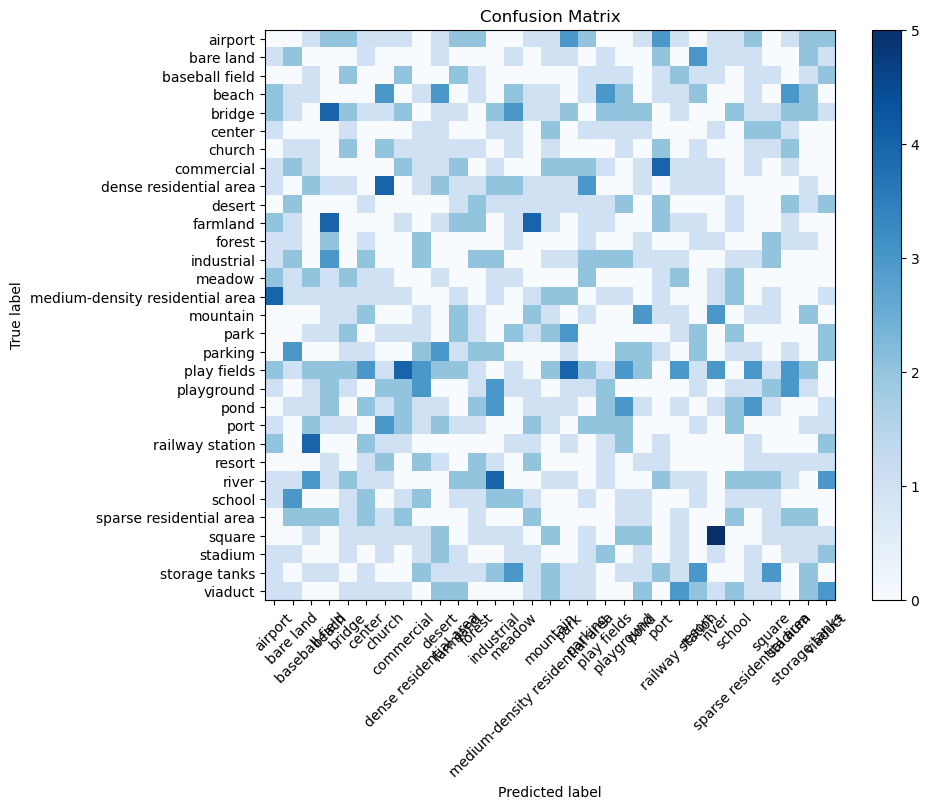

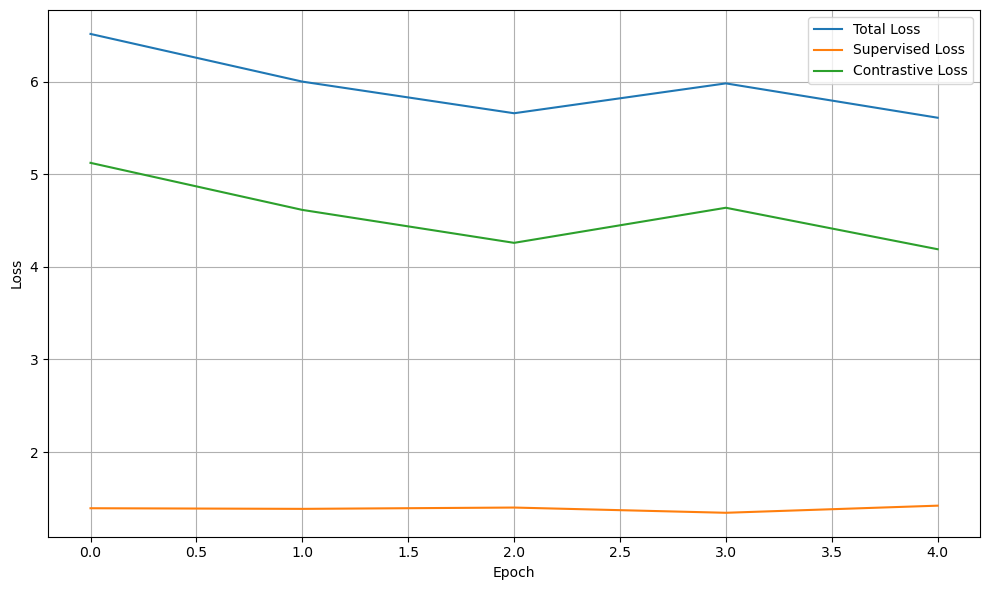

Final Precision (Macro): 0.0343
Final Recall (Macro): 0.0343
Final F1 Score (Macro): 0.0338


In [45]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn
from torch.cuda.amp import autocast, GradScaler

model.train()
projection_head.train()
initial_temperature = 0.07
temperature = nn.Parameter(torch.tensor(initial_temperature).to(device))
optimizer = AdamW(
    list(model.parameters()) + list(projection_head.parameters()) + [temperature],
    lr=1e-5, weight_decay=0.01
)
lambda_contrastive = 1

torch.cuda.empty_cache()
scaler = GradScaler()

num_epochs = 5
all_preds = []
all_labels = []
supervised_losses = []
contrastive_losses = []
total_losses = []

for epoch in range(num_epochs):
    running_loss = 0
    running_sup_loss = 0
    running_con_loss = 0

    labeled_iter = iter(labeled_loader_semi_super)
    unlabeled_loop = iter(unlabeled_loader)

    max_steps = max(len(labeled_loader_semi_super), len(unlabeled_loader))
    loop = tqdm(range(max_steps), leave=False)

    epoch_preds = []
    epoch_labels = []

    for step in loop:
        try:
            images_labeled, captions, labels, class_name = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader_semi_super)
            images_labeled, captions, labels, class_name = next(labeled_iter)

        images_labeled = images_labeled.to(device)
        tokens = tokenizer(captions).to(device)

        try:
            images_unlabeled = next(unlabeled_loop)
        except StopIteration:
            unlabeled_loop = iter(unlabeled_loader)
            images_unlabeled = next(unlabeled_loop)

        images_unlabeled = images_unlabeled.to(device)

        with autocast():
            # --- Supervised Loss ---
            image_features_supervised = model.encode_image(images_labeled)
            text_features = model.encode_text(tokens)
            logits_per_image = image_features_supervised @ text_features.T / temperature
            ground_truth = torch.arange(len(images_labeled), device=device)
            loss_image_supervised = F.cross_entropy(logits_per_image, ground_truth)
            logits_per_text = text_features @ image_features_supervised.T / temperature
            loss_text_supervised = F.cross_entropy(logits_per_text, ground_truth)
            loss_supervised = (loss_image_supervised + loss_text_supervised) / 2

            # --- Contrastive Loss ---
            image_unlabeled1 = augment(images_unlabeled)
            image_unlabeled2 = augment(images_unlabeled)
            features1 = model.encode_image(image_unlabeled1)
            features2 = model.encode_image(image_unlabeled2)
            loss_contrastive = contrastive_loss(projection_head(features1), projection_head(features2), temperature)

            # --- Total Loss ---
            loss_total = loss_supervised + lambda_contrastive * loss_contrastive

        scaler.scale(loss_total).backward()
        all_params = list(model.parameters()) + list(projection_head.parameters()) + [temperature]
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loop.set_postfix(loss_sup=loss_supervised.item(), loss_con=loss_contrastive.item())
        running_loss += loss_total.item()
        running_sup_loss += loss_supervised.item()
        running_con_loss += loss_contrastive.item()

    avg_total_loss = running_loss / len(labeled_loader_semi_super)
    avg_sup_loss = running_sup_loss / len(labeled_loader_semi_super)
    avg_con_loss = running_con_loss / len(labeled_loader_semi_super)

    total_losses.append(avg_total_loss)
    supervised_losses.append(avg_sup_loss)
    contrastive_losses.append(avg_con_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_total_loss:.4f}")

model.eval()
projection_head.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images_labeled, captions, labels, _ in train_loader:
        images_labeled = images_labeled.to(device)
        tokens = tokenizer(captions).to(device)

        image_features = model.encode_image(images_labeled)
        text_features = model.encode_text(tokens)
        logits_per_image = image_features @ text_features.T / temperature

        preds = logits_per_image.argmax(dim=1).cpu().numpy()
        true_labels = [class_names.index(lbl) for lbl in labels]  # string to index

        all_preds.extend(preds)
        all_labels.extend(true_labels)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.close()

# --- Loss Curve Plot ---
plt.figure(figsize=(10, 6))
plt.plot(total_losses, label='Total Loss')
plt.plot(supervised_losses, label='Supervised Loss')
plt.plot(contrastive_losses, label='Contrastive Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print metrics ---
print(f"Final Precision (Macro): {precision:.4f}")
print(f"Final Recall (Macro): {recall:.4f}")
print(f"Final F1 Score (Macro): {f1:.4f}")


In [11]:
for obj in dir():
    if 'tensor' in str(type(eval(obj))):
        del globals()[obj]
torch.cuda.empty_cache()


# Pre-train with contrastive loss of augmentations

In [5]:
from torch import nn

projection_head = nn.Sequential(
    nn.Linear(512, 512),  # or whatever your encoder output dim is
    nn.ReLU(),
    nn.Linear(512, 128)   # embedding size for contrastive comparison
).to(device)


In [19]:
def knn_accuracy(encoder, projection_head, train_loader, val_loader, k=5):
    encoder.eval()
    projection_head.eval()

    # Build feature bank
    feature_bank = []
    label_bank = []
    with torch.no_grad():
        for images, _, labels, _ in train_loader:
            images = images.to(device)
            features = encoder.encode_image(images)
            features = projection_head(features)
            features = F.normalize(features, dim=1)
            feature_bank.append(features)
            label_bank.extend([lbl.lower() for lbl in labels])

    feature_bank = torch.cat(feature_bank, dim=0)
    label_bank = np.array(label_bank)

    correct = total = 0
    with torch.no_grad():
        for images, _, labels, _ in train_loader:
            images = images.to(device)
            features = encoder.encode_image(images)
            features = projection_head(features)
            features = F.normalize(features, dim=1)

            sim = torch.mm(features, feature_bank.T)  # cosine sim
            topk = sim.topk(k=k, dim=-1).indices  # top-k indices

            pred_labels = []
            for indices in topk:
                votes = label_bank[indices.cpu().numpy()]
                pred_labels.append(max(set(votes), key=list(votes).count))

            correct += sum(p == l.lower() for p, l in zip(pred_labels, labels))
            total += len(labels)

    return correct / total


In [26]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn 

model.train()
initial_temperature = 0.07
temperature = nn.Parameter(torch.tensor(initial_temperature).to(device))
optimizer = AdamW(
    list(model.parameters()) + list(projection_head.parameters()) + [temperature],
    lr=5e-6, weight_decay=0.01
)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0
    unlabeled_loop = iter(unlabeled_loader)
    loop = tqdm(range(len(unlabeled_loader)), leave=False)

    for step in loop:
        try:
            images_unlabeled = next(unlabeled_loop)
        except StopIteration:
            unlabeled_loop = iter(unlabeled_loader)
            images_unlabeled = next(unlabeled_loop)

        loss = contrastive_loss(z1, z2, temperature)

        images_unlabeled = images_unlabeled.to(device)

        # Generate two augmentations
        view1 = augment(images_unlabeled)
        view2 = augment(images_unlabeled)

        # Encode both views
        z1 = model.encode_image(view1)  # [batch_size, dim]
        z2 = model.encode_image(view2)  # [batch_size, dim]


        z1 = projection_head(z1)
        z2 = projection_head(z2)

        loss = contrastive_loss(z1, z2, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        running_loss += loss.item()

    acc = knn_accuracy(model, projection_head, train_loader, val_loader)
    print(f"KNN Validation Accuracy: {acc:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Contrastive Loss: {running_loss / len(unlabeled_loader):.4f}")


KNN Validation Accuracy: 0.9451
Epoch 1/10 - Avg Contrastive Loss: 0.6089


KNN Validation Accuracy: 0.9406
Epoch 2/10 - Avg Contrastive Loss: 0.5329


KNN Validation Accuracy: 0.9474
Epoch 3/10 - Avg Contrastive Loss: 0.5440


KNN Validation Accuracy: 0.9417
Epoch 4/10 - Avg Contrastive Loss: 0.6184


KNN Validation Accuracy: 0.9463
Epoch 5/10 - Avg Contrastive Loss: 0.5573


KNN Validation Accuracy: 0.9383
Epoch 6/10 - Avg Contrastive Loss: 0.5204


KNN Validation Accuracy: 0.9371
Epoch 7/10 - Avg Contrastive Loss: 0.6423


KNN Validation Accuracy: 0.9406
Epoch 8/10 - Avg Contrastive Loss: 0.5076


KNN Validation Accuracy: 0.9394
Epoch 9/10 - Avg Contrastive Loss: 0.5527


KNN Validation Accuracy: 0.9440
Epoch 10/10 - Avg Contrastive Loss: 0.5498


In [25]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn 

model.train()
initial_temperature = 0.07
temperature = nn.Parameter(torch.tensor(initial_temperature).to(device))
optimizer = AdamW(
    list(model.parameters()) + list(projection_head.parameters()) + [temperature],
    lr=5e-6, weight_decay=0.01
)

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    
    loop = tqdm(train_loader, leave=False)
    for batch in loop:
        images_unlabeled, _, _, _ = batch
        images_unlabeled = images_unlabeled.to(device)

        # Generate two augmentations
        view1 = augment(images_unlabeled)
        view2 = augment(images_unlabeled)

        # Encode both views
        z1 = model.encode_image(view1)
        z2 = model.encode_image(view2)

        z1 = projection_head(z1)
        z2 = projection_head(z2)

        loss = contrastive_loss(z1, z2, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        running_loss += loss.item()

    model.eval()
    acc = knn_accuracy(model, projection_head, train_loader, val_loader)
    print(f"KNN Validation Accuracy: {acc:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Contrastive Loss: {running_loss / len(train_loader):.4f}")


KNN Validation Accuracy: 0.9371
Epoch 1/5 - Avg Contrastive Loss: 0.3532


KNN Validation Accuracy: 0.9303
Epoch 2/5 - Avg Contrastive Loss: 0.3775


KNN Validation Accuracy: 0.9451
Epoch 3/5 - Avg Contrastive Loss: 0.4026


KNN Validation Accuracy: 0.9314
Epoch 4/5 - Avg Contrastive Loss: 0.4444


KNN Validation Accuracy: 0.9394
Epoch 5/5 - Avg Contrastive Loss: 0.2690


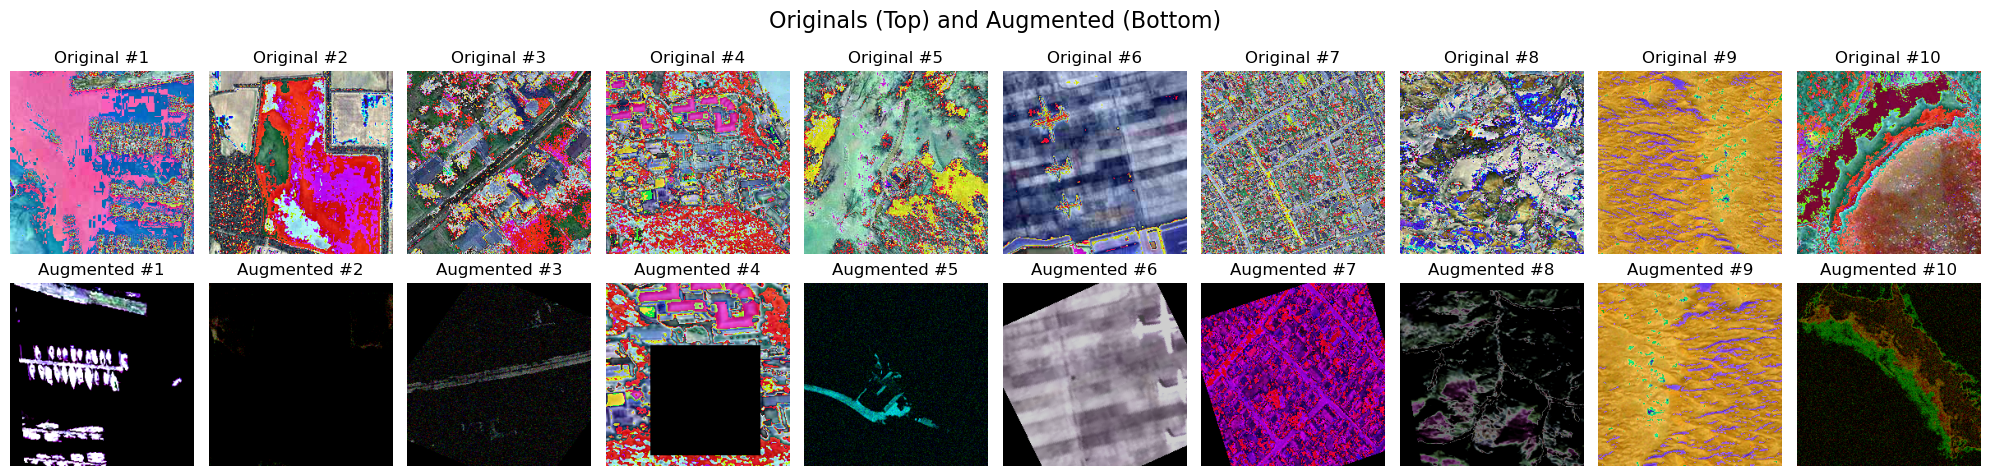

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Get one batch from the unlabeled loader
images_unlabeled = next(iter(unlabeled_loader))
images_unlabeled = images_unlabeled[:10]  # 10 originals → 20 total when paired with augmentations

# Apply augmentations
augmented_images = [augment(img.unsqueeze(0)).squeeze(0) for img in images_unlabeled]

# Convert to CPU for plotting
originals = [TF.to_pil_image(img.cpu()) for img in images_unlabeled]
augmented = [TF.to_pil_image(img.cpu()) for img in augmented_images]

# Plot: 2 rows (original + augmented), 10 columns
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i in range(10):
    axes[0, i].imshow(originals[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original #{i+1}")

    axes[1, i].imshow(augmented[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Augmented #{i+1}")

plt.suptitle("Originals (Top) and Augmented (Bottom)", fontsize=16)
plt.tight_layout()
plt.show()


In [20]:
acc = knn_accuracy(model, projection_head, train_loader, val_loader)
print(f"KNN Validation Accuracy: {acc:.4f}")

KNN Validation Accuracy: 0.9497


/tmp/ipykernel_689670/3379515226.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(class_names))


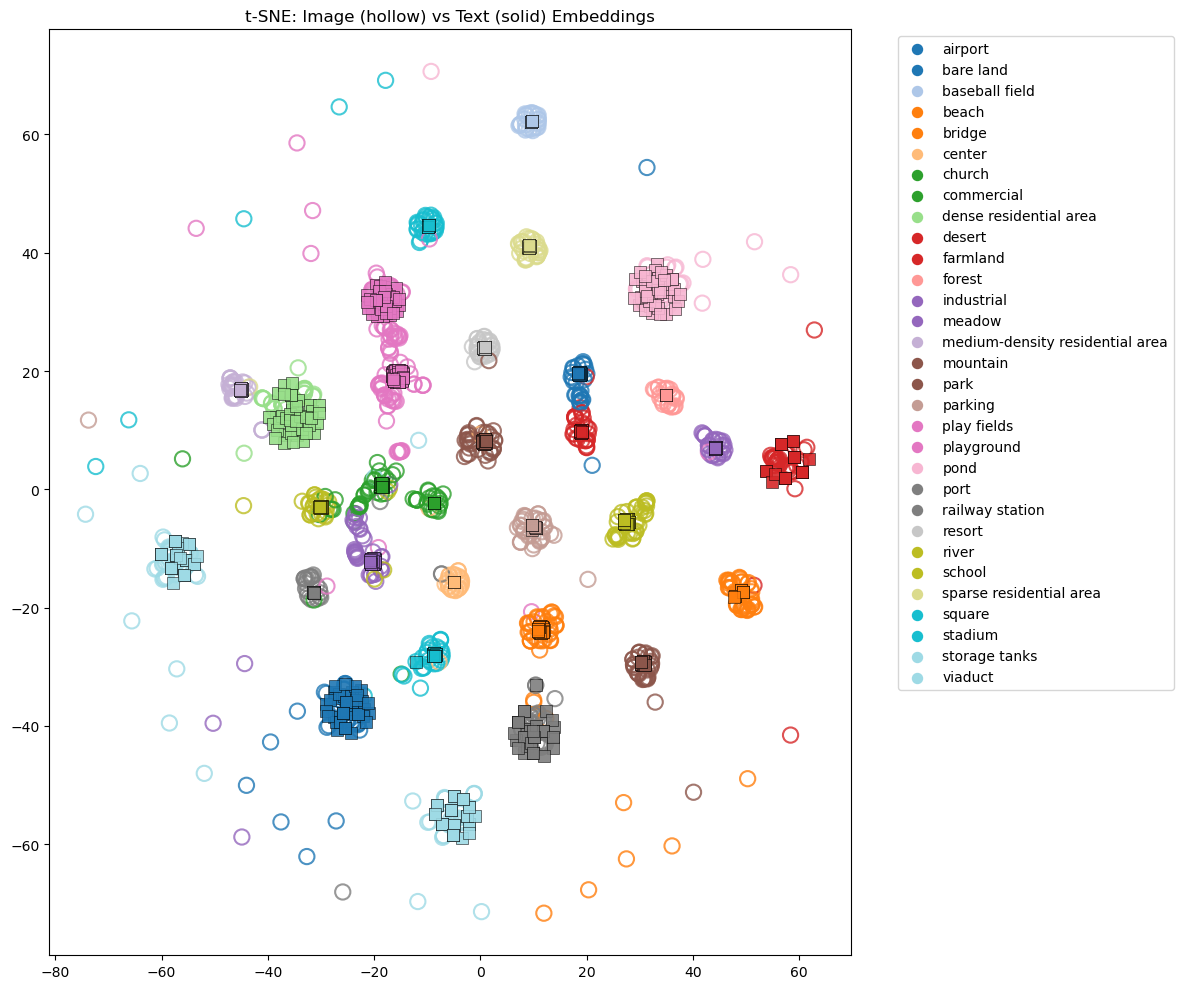

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

all_image_embeddings = []
all_text_embeddings = []
all_labels = []

model.eval()
projection_head.eval()

with torch.no_grad():
    for images_labeled, captions, labels, _ in test_loader:
        images_labeled = images_labeled.to(device)
        texts = [f"This is a satellite photo of a {label}" for label in labels]
        tokens = tokenizer(texts).to(device)

        image_feats = model.encode_image(images_labeled)
        text_feats = model.encode_text(tokens)

        image_feats = F.normalize(image_feats, dim=-1).cpu()
        text_feats = F.normalize(text_feats, dim=-1).cpu()

        all_image_embeddings.append(image_feats)
        all_text_embeddings.append(text_feats)
        all_labels.extend([class_names.index(lbl) for lbl in labels])

all_image_embeddings = torch.cat(all_image_embeddings)
all_text_embeddings = torch.cat(all_text_embeddings)

embeddings_combined = torch.cat([all_image_embeddings, all_text_embeddings])
labels_combined = all_labels * 2
is_text = [0] * len(all_labels) + [1] * len(all_labels)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(embeddings_combined)

# Plot
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap("tab20", len(class_names))

for i in range(len(proj)):
    class_id = labels_combined[i]
    if is_text[i]:
        # Text embedding: solid square
        plt.scatter(proj[i, 0], proj[i, 1],
                    color=colors(class_id),
                    s=80, marker='s', alpha=0.9, edgecolors='black', linewidths=0.4)
    else:
        # Image embedding: hollow circle
        plt.scatter(proj[i, 0], proj[i, 1],
                    facecolors='none', edgecolors=colors(class_id),
                    s=120, marker='o', linewidths=1.5, alpha=0.8)

# Class legend
for i, name in enumerate(class_names):
    plt.scatter([], [], color=colors(i), label=name)
plt.legend(markerscale=1.2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Image (hollow) vs Text (solid) Embeddings")
plt.tight_layout()
plt.show()


# Freeze image encoder

Epoch 1/30 - Avg Loss: 0.1440


Epoch 2/30 - Avg Loss: 0.1272


Epoch 3/30 - Avg Loss: 0.1243


Epoch 4/30 - Avg Loss: 0.1231


Epoch 5/30 - Avg Loss: 0.1223


Epoch 6/30 - Avg Loss: 0.1225


Epoch 7/30 - Avg Loss: 0.1219


Epoch 8/30 - Avg Loss: 0.1214


Epoch 9/30 - Avg Loss: 0.1214


Epoch 10/30 - Avg Loss: 0.1219


Epoch 11/30 - Avg Loss: 0.1202


Epoch 12/30 - Avg Loss: 0.1204


Epoch 13/30 - Avg Loss: 0.1200


Epoch 14/30 - Avg Loss: 0.1203


Epoch 15/30 - Avg Loss: 0.1204


Epoch 16/30 - Avg Loss: 0.1203


Epoch 17/30 - Avg Loss: 0.1197


Epoch 18/30 - Avg Loss: 0.1203


Epoch 19/30 - Avg Loss: 0.1207


Epoch 20/30 - Avg Loss: 0.1198


Epoch 21/30 - Avg Loss: 0.1201


Epoch 22/30 - Avg Loss: 0.1193


Epoch 23/30 - Avg Loss: 0.1201


Epoch 24/30 - Avg Loss: 0.1201


Epoch 25/30 - Avg Loss: 0.1195


Epoch 26/30 - Avg Loss: 0.1201


Epoch 27/30 - Avg Loss: 0.1195


Epoch 28/30 - Avg Loss: 0.1197


Epoch 29/30 - Avg Loss: 0.1194


Epoch 30/30 - Avg Loss: 0.1191


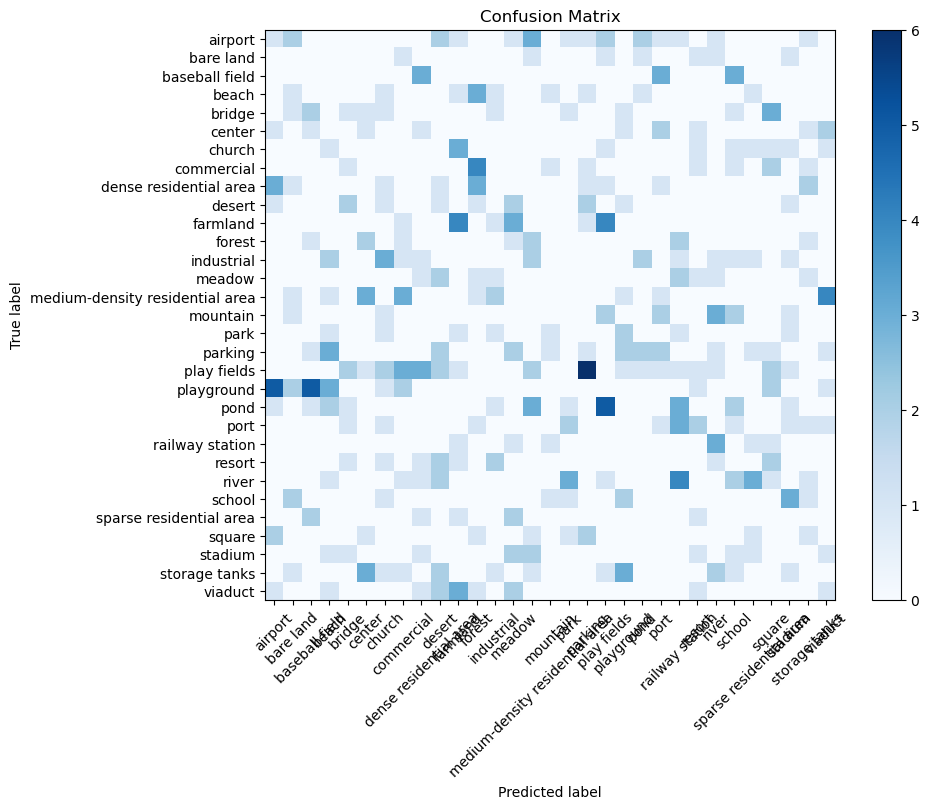

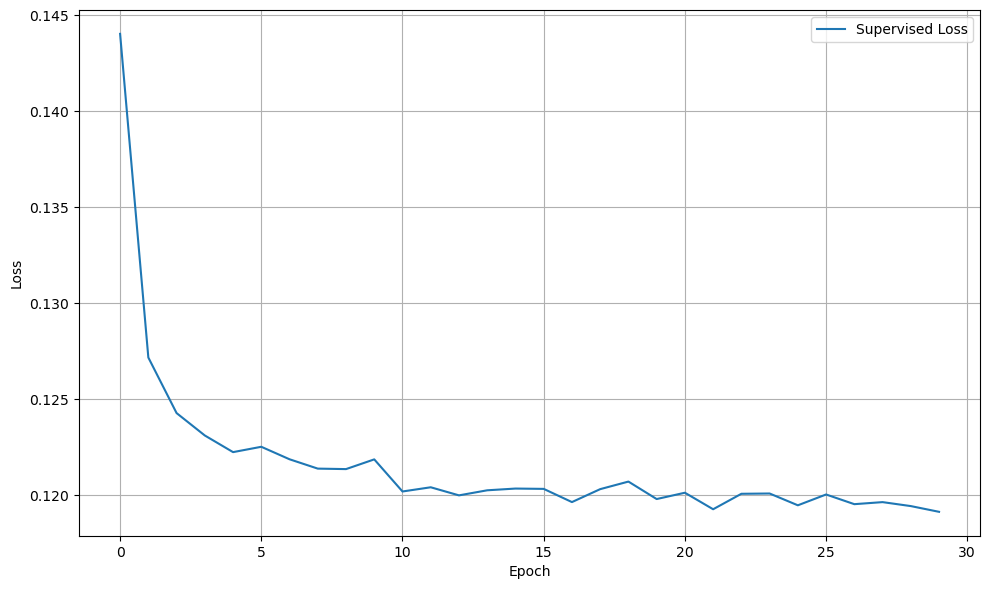

Final Precision (Macro): 0.0118
Final Recall (Macro): 0.0060
Final F1 Score (Macro): 0.0078


In [36]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch import nn
from torch.cuda.amp import autocast, GradScaler

# --- Freeze image encoder ---
for name, param in model.named_parameters():
    if "visual" in name:
        param.requires_grad = False

# --- Trainable parts ---
temperature = nn.Parameter(torch.tensor(0.07).to(device))
trainable_params = list(filter(lambda p: p.requires_grad, model.parameters())) \
                 + list(projection_head.parameters()) \
                 + [temperature]

optimizer = AdamW(trainable_params, lr=1e-4, weight_decay=0.01)
scaler = GradScaler()

model.train()
projection_head.train()
torch.cuda.empty_cache()

num_epochs = 30
supervised_losses = []
total_losses = []

for epoch in range(num_epochs):
    running_loss = 0

    labeled_iter = iter(labeled_loader_semi_super)
    loop = tqdm(range(len(labeled_loader_semi_super)), leave=False)

    for _ in loop:
        try:
            images_labeled, captions, labels, _ = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader_semi_super)
            images_labeled, captions, labels, _ = next(labeled_iter)

        images_labeled = images_labeled.to(device)


        texts = [f"This is a satellite photo of a {label}" for label in labels]
        tokens = tokenizer(texts).to(device)


        with autocast():
            image_features = F.normalize(model.encode_image(images_labeled), dim=-1)
            text_features = F.normalize(model.encode_text(tokens), dim=-1)
            loss = 1 - F.cosine_similarity(text_features, image_features, dim=-1).mean()

            # image_features = model.encode_image(images_labeled)  # Frozen, just used
            # text_features = model.encode_text(tokens)
            # logits_per_image = image_features @ text_features.T / temperature
            # ground_truth = torch.arange(len(images_labeled), device=device)
            # loss_image = F.cross_entropy(logits_per_image, ground_truth)

            # logits_per_text = text_features @ image_features.T / temperature
            # loss_text = F.cross_entropy(logits_per_text, ground_truth)

            # loss = (loss_image + loss_text) / 2

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())
        running_loss += loss.item()

    avg_loss = running_loss / len(labeled_loader_semi_super)
    supervised_losses.append(avg_loss)
    total_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

# --- Evaluation ---
model.eval()
projection_head.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images_labeled, captions, labels, _ in train_loader:
        images_labeled = images_labeled.to(device)
        tokens = tokenizer(captions).to(device)

        image_features = model.encode_image(images_labeled)
        text_features = model.encode_text(tokens)
        logits = image_features @ text_features.T / temperature
        preds = logits.argmax(dim=1).cpu().numpy()
        true = [class_names.index(lbl) for lbl in labels]

        all_preds.extend(preds)
        all_labels.extend(true)

# --- Metrics ---
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(10, 6))
plt.plot(supervised_losses, label='Supervised Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Final metrics ---
print(f"Final Precision (Macro): {precision:.4f}")
print(f"Final Recall (Macro): {recall:.4f}")
print(f"Final F1 Score (Macro): {f1:.4f}")


## Save model

In [66]:
torch.save({
    'model_state_dict': model.state_dict(),
    'projection_head_state_dict': projection_head.state_dict(),
    'temperature': temperature.item()
}, '94_model.pt')

In [6]:
checkpoint = torch.load('94_model.pt', map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
projection_head.load_state_dict(checkpoint['projection_head_state_dict'])
temperature = torch.tensor(checkpoint['temperature'], requires_grad=True, device=device)
